In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from random import sample

In [2]:
nielsen15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
nielsen16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
nielsen15['year'] = 2015
nielsen16['year'] = 2016

nielsen = pd.concat((nielsen15, nielsen16))
nielsen = nielsen[~nielsen.is_walmart]
density_path = r"C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\Average_Household_Size_and_Population_Density_-_County.csv"
density = pd.read_csv(density_path)
density = density[["GEOID", "B01001_calc_PopDensity"]]
nielsen = pd.merge(nielsen, density,  how='inner', left_on='guessed_store_county_fips', right_on='GEOID')
nielsen = nielsen.rename(columns={"B01001_calc_PopDensity": "Population density (people/km^2)"})

## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes stillremain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]
nielsen = nielsen[~np.isin(nielsen.store_state, ('CA', 'GA', 'KS', 'LA', 'TX'))]

# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]
#movements['year'] = movements.Opening_date.dt.year
#movements['month'] = movements.Opening_date.dt.month

In [3]:
#nielsen.groupby('product_group_descr').mean().sort_values('upc_price_std', ascending=True).head(30)

In [4]:
categories = [
    "FRESH PRODUCE",
    "BREAD AND BAKED GOODS",
    "MILK",
    "SNACKS",
    "PACKAGED MEATS-DELI",
    "CHEESE",
    "UNPREP MEAT/POULTRY/SEAFOOD-FRZN",
    "CARBONATED BEVERAGES",
    "CONDIMENTS, GRAVIES, AND SAUCES",
    "CANDY",
    "JUICE, DRINKS - CANNED, BOTTLED",
    "EGGS",
    "CEREAL",
    "PASTA",
    "COT CHEESE, SOUR CREAM, TOPPINGS",
    "PAPER PRODUCTS",
    "YOGURT"
]
state_for_cat = {"FRESH PRODUCE" : "FL",
    "BREAD AND BAKED GOODS" : "FL",
    "MILK" : "FL",
    "SNACKS" : "FL",
    "PACKAGED MEATS-DELI" : "FL",
    "CHEESE" : "FL",
    "UNPREP MEAT/POULTRY/SEAFOOD-FRZN" : "FL",
    "CARBONATED BEVERAGES" : "FL",
    "CONDIMENTS, GRAVIES, AND SAUCES" : "FL",
    "CANDY" : "FL",
    "JUICE, DRINKS - CANNED, BOTTLED" : "FL",
    "EGGS" : "FL",
    "CEREAL" : "FL",
    "PASTA" : "FL"}

## PREMIER MODELE

$$Prices_{i, t} = \alpha + \beta treat_i + \gamma treat_i* post_t$$

In [301]:
state = "FL"

In [302]:
#We choose to focus on milk prices
#for category in categories:
#    product_group = nielsen[(nielsen.product_group_descr == category)&(nielsen.store_state == state)]

product_group = nielsen[(nielsen.store_state == state)]
# The control group is composed by all states where nothing (no entry nor exit) happened.
control = product_group[~np.isin(product_group.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.State == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
treatment_movements = treatment_movements[(treatment_movements.Opening_date>='2015-01-31' ) & (treatment_movements.Opening_date<='2017-01-31') & ((treatment_movements.Closing_date>'2017-01-31') | (treatment_movements.Closing_date.apply(str) == 'NaT'))]

treatment = product_group[np.isin(product_group.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
control['interaction'] = False

treatment['treat'] = True
treatment['interaction'] = (((treatment.purchase_month > treatment.Opening_date.dt.month) & (treatment.purchase_year == treatment.Opening_date.dt.year))|
                           (treatment.purchase_year > treatment.Opening_date.dt.year))


# Final dataset for the regression :

df = pd.concat((control, treatment))[['upc_price', 'treat', 'interaction']]
df = df[df.upc_price != 0]

Size of the control group: 39.
Size of the treatment group: 10.


In [303]:
reg0 = smf.ols(formula='np.log(upc_price) ~ treat + interaction', data=df)
results0 = reg0.fit()
if abs(results0.params[2] / results0.bse[2]) > 0. :
    print("=========================================================")
#    print(category)
    print(f"Coef : {np.exp(results0.params[2])-1}")
    print(f"Coef/err : {abs(results0.params[2] / results0.bse[2])}")
    print(f"CI_up : {np.exp(results0.conf_int(alpha=0.05)[0][2])-1}")
    print(f"CI_down : {np.exp(results0.conf_int(alpha=0.05)[1][2])-1}")

Coef : 0.029492975603897298
Coef/err : 3.2867990385096095
CI_up : 0.011802582813581042
CI_down : 0.04749266785874484


## Building a better control group

In [50]:
# Selection of a promising (state, category), that is, statisticaly significant 
# interaction term for the model with time fixed effects, and a pattern that makes sense to us (negative term)
state = "SC"
category = "JUICE, DRINKS - CANNED, BOTTLED"
d_min = 100
d_max = 200
# coeff/stde = 2.8, coeff = -0.08

In [51]:
#for state in states :
    # 
product_group = nielsen[(nielsen.product_group_descr == category)
                        #&(nielsen.store_state == state)
                       ]
    # The control group is composed by all states where nothing (no entry nor exit) happened.
control = product_group[~np.isin(product_group.guessed_store_county_fips, movements)].copy()

# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.State == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
treatment_movements = treatment_movements[(treatment_movements.Opening_date>='2015-01-31' ) & (treatment_movements.Opening_date<='2017-01-31') & ((treatment_movements.Closing_date>'2017-01-31') | (treatment_movements.Closing_date.apply(str) == 'NaT'))]

treatment = product_group[np.isin(product_group.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')

# We create our dummies for the regression
control['treat'] = False
control['interaction'] = False
control['time_effects'] = list(zip(control.purchase_year, control.purchase_month))

treatment['treat'] = True
treatment['interaction'] = (((treatment.purchase_month > treatment.Opening_date.dt.month) & (treatment.purchase_year == treatment.Opening_date.dt.year))|
                           (treatment.purchase_year > treatment.Opening_date.dt.year))
treatment['time_effects'] = list(zip(treatment.purchase_year, treatment.purchase_month))

control = control[(control["Population density (people/km^2)"]>=d_min)&(control["Population density (people/km^2)"]<=d_max)]
treatment = treatment[(treatment["Population density (people/km^2)"]>=d_min)&(treatment["Population density (people/km^2)"]<=d_max)]
mask0 = control.groupby('guessed_store_county_fips').count()
mask0 = mask0[mask0.is_walmart > 20]
control = pd.merge(control, mask0, on = "guessed_store_county_fips")
n_t = len(treatment.guessed_store_county_fips.unique())
c_county_list = control.guessed_store_county_fips.unique().copy().tolist()
if len(c_county_list) > n_t :
    c_county_list = sample(c_county_list, n_t)
    control = control[control.guessed_store_county_fips.isin(c_county_list)]

# Final dataset for the regression :q

df0 = pd.concat((control, treatment))
df = df0[['upc_price', 'treat', 'interaction','time_effects']]
df = df[df.upc_price != 0]
reg0 = smf.ols(formula='np.log(upc_price) ~ treat + interaction + C(time_effects)', data=df)
results0 = reg0.fit()

if abs(results0.params[2] / results0.bse[2]) > 0. :
    print("=========================================================")
 #   print(state)
    print(f"Coef : {np.exp(results0.params[2])-1}")
    print(f"Coef/err : {abs(results0.params[2] / results0.bse[2])}")
    print(f"CI_up : {np.exp(results0.conf_int(alpha=0.05)[0][2])-1}")
    print(f"CI_down : {np.exp(results0.conf_int(alpha=0.05)[1][2])-1}")

Coef : -0.06303124110543235
Coef/err : 3.169364497558745
CI_up : -0.10009364895080108
CI_down : -0.024442427680533174


In [23]:
c_county_list = control.guessed_store_county_fips.unique().copy().tolist()
c_county_list

[12009, 21015, 24025]

In [10]:
a = [0, 1, 2]
sample(a, 1)

[2]

In [13]:
results0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(upc_price)   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     2.132
Date:                Tue, 08 Nov 2022   Prob (F-statistic):            0.00407
Time:                        00:01:12   Log-Likelihood:                 127.03
No. Observations:                 144   AIC:                            -204.1
Df Residuals:                     119   BIC:                            -129.8
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.6010      0.022     26.727      0.000       0.557       0.646
treat[T.True]                     0.6010      0.022     26.727      0.000       0.557       0.646
interaction[T.True]              -0.1052      0.025     -4.252      0.000      -0.154      -0.056
C(time_effects)[T.(2015, 2)]     -0.0116      0.064     -0.183      0.855      -0.138       0.114
C(time_effects)[T.(2015, 3)]     -0.0543      0.064     -0.854      0.395      -0.180       0.072
C(time_effects)[T.(2015, 4)]     -0.1071      0.064     -1.683      0.095      -0.233       0.019
C(time_effects)[T.(2015, 5)]     -0.1459      0.064     -2.293      0.024      -0.272      -0.020
C(time_effects)[T.(2015, 6)]     -0.0519      0.064     -0.813      0.418      -0.178       0.074
C(time_effects)[T.(2015, 7)]     -0.0761      0.064     -1.194      0.235      -0.202       0.050
C(time_effects)[T.(2015, 8)]     -0.0437      0.064     -0.686      0.494      -0.170       0.082
C(time_effects)[T.(2015, 9)]     -0.0529      0.064     -0.830      0.408      -0.179       0.073
C(time_effects)[T.(2015, 10)]     0.0224      0.064      0.352      0.726      -0.104       0.149
C(time_effects)[T.(2015, 11)]    -0.1293      0.064     -2.028      0.045      -0.255      -0.003
C(time_effects)[T.(2015, 12)]    -0.0754      0.064     -1.176      0.242      -0.202       0.052
C(time_effects)[T.(2016, 1)]      0.0274      0.064      0.427      0.670      -0.100       0.154
C(time_effects)[T.(2016, 2)]     -0.0327      0.065     -0.504      0.615      -0.161       0.096
C(time_effects)[T.(2016, 3)]     -0.0619      0.065     -0.955      0.341      -0.190       0.066
C(time_effects)[T.(2016, 4)]     -0.0806      0.065     -1.244      0.216      -0.209       0.048
C(time_effects)[T.(2016, 5)]     -0.0612      0.066     -0.931      0.354      -0.191       0.069
C(time_effects)[T.(2016, 6)]     -0.0295      0.066     -0.449      0.654      -0.160       0.101
C(time_effects)[T.(2016, 7)]     -0.0182      0.067     -0.272      0.786      -0.151       0.114
C(time_effects)[T.(2016, 8)]      0.0051      0.067      0.077      0.939      -0.127       0.138
C(time_effects)[T.(2016, 9)]     -0.0620      0.067     -0.927      0.356      -0.194       0.070
C(time_effects)[T.(2016, 10)]     0.0133      0.067      0.199      0.843      -0.119       0.146
C(time_effects)[T.(2016, 11)]    -0.1286      0.067     -1.924      0.057      -0.261       0.004
C(time_effects)[T.(2016, 12)]    -0.0539      0.067     -0.806      0.422      -0.186       0.079
==============================================================================
Omnibus:                        0.204   Durbin-Watson:                   1.129
Prob(Omnibus):                  0.903   Jarque-Bera (JB):                0.200
Skew

In [307]:
y_hat = results0.fittedvalues
u_hat = results0.resid
y_hat = y_hat.rename("fitted_value").to_frame()
u_hat = u_hat.rename("residual").to_frame()

In [308]:
new0 = pd.merge(df0, y_hat, left_index=True, right_index=True)
new = pd.merge(new0, u_hat, left_index=True, right_index=True)
new['date']=new['purchase_month']+12*(new['purchase_year']-2015)
new['fitted_value']=np.exp(new['fitted_value'])-1
new['residual']= new['upc_price']-new['fitted_value']
new['s_residual']=new['residual']**2
new = new[['upc_price', 'nb_of_obs', 
       'Population density (people/km^2)', 'treat',
       'interaction', 'time_effects', 'store_state', 'guessed_store_county',
       'guessed_store_county_fips',
       'Opening_date', 'Closing_date', 'fitted_value', 'residual', 'date', 's_residual']]

In [309]:
new_t = new[new.treat]
new_c = new[~new.treat]
new_t_i = new_t[new_t.interaction]
new_t_ni = new_t[~new_t.interaction]

### 1. Nb of counties in control and treatment groups, density distribution

8.71753759395985 166.025133721354


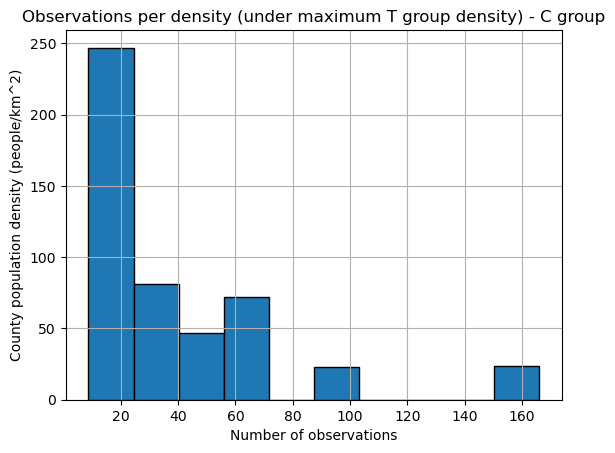

In [341]:
print(control["Population density (people/km^2)"].min(),control["Population density (people/km^2)"].max())
plt.hist(control["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - C group')
#plt.ylim(0, 3000)
plt.grid(True)
plt.show()
#savefig("../../results_summary/density_control_hist_0.png")

In [333]:
#control group analysis
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")
print(f"Size of the control group: {control.guessed_store_county_fips.count()}.")
control_d = control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()

Size of the control group: 28.
Size of the control group: 494.


C:\Users\inesn\AppData\Local\Temp\ipykernel_35628\2391365913.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  control_d = control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()


In [334]:
control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).count().head(50)

is_walmart  \
store_state guessed_store_county_fips guessed_store_county               
SC          45001                     ABBEVILLE                     19   
            45003                     AIKEN                         24   
            45005                     ALLENDALE                      5   
            45009                     BAMBERG                       12   
            45011                     BARNWELL                       4   
            45017                     CALHOUN                       24   
            45019                     CHARLESTON                    24   
            45021                     CHEROKEE                      23   
            45023                     CHESTER                       24   
            45025                     CHESTERFIELD                  24   
            45027                     CLARENDON                     13   
            45029                     COLLETON                       6   
            45033                     DILLON                        11   
            45037                     EDGEFIELD                      1   
            45041                     FLORENCE                      24   
            45049                     HAMPTON                       21   
            45053                     JASPER                         8   
            45055                     KERSHAW                       23   
            45057                     LANCASTER                     24   
            45067                     MARION                        23   
            45069                     MARLBORO                      24   
            45071                     NEWBERRY                      24   
            45073                     OCONEE                        24   
            45075                     ORANGEBURG                    24   
            45077                     PICKENS                       23   
            45081                     SALUDA                         5   
            45087                     UNION                         12   
            45089                     WILLIAMSBURG                  21   

                                                            purchase_year  \
store_state guessed_store_county_fips guessed_store_county                  
SC          45001                     ABBEVILLE                        19   
            45003                     AIKEN                            24   
            45005                     ALLENDALE                         5   
            45009                     BAMBERG                          12   
            45011                     BARNWELL                          4   
            45017                     CALHOUN                          24   
            45019                     CHARLESTON                       24   
            45021                     CHEROKEE                         23   
            45023                     CHESTER                          24   
            45025                     CHESTERFIELD                     24   
            45027                     CLARENDON                        13   
            45029                     COLLETON                          6   
            45033                     DILLON                           11   
            45037                     EDGEFIELD                         1   
            45041                     FLORENCE                         24   
            45049                     HAMPTON                          21   
            45053                     JASPER                            8   
            45055                     KERSHAW                          23   
            45057                     LANCASTER                        24   
            45067                     MARION                           23   
            45069                     MARLBORO                         24   
            45071                     NEWBERRY                      

In [340]:
control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean().head(50)

C:\Users\inesn\AppData\Local\Temp\ipykernel_35628\462922393.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean().head(50)


is_walmart  \
store_state guessed_store_county_fips guessed_store_county               
SC          45001                     ABBEVILLE                    0.0   
            45003                     AIKEN                        0.0   
            45005                     ALLENDALE                    0.0   
            45009                     BAMBERG                      0.0   
            45011                     BARNWELL                     0.0   
            45017                     CALHOUN                      0.0   
            45019                     CHARLESTON                   0.0   
            45021                     CHEROKEE                     0.0   
            45023                     CHESTER                      0.0   
            45025                     CHESTERFIELD                 0.0   
            45027                     CLARENDON                    0.0   
            45029                     COLLETON                     0.0   
            45033                     DILLON                       0.0   
            45037                     EDGEFIELD                    0.0   
            45041                     FLORENCE                     0.0   
            45049                     HAMPTON                      0.0   
            45053                     JASPER                       0.0   
            45055                     KERSHAW                      0.0   
            45057                     LANCASTER                    0.0   
            45067                     MARION                       0.0   
            45069                     MARLBORO                     0.0   
            45071                     NEWBERRY                     0.0   
            45073                     OCONEE                       0.0   
            45075                     ORANGEBURG                   0.0   
            45077                     PICKENS                      0.0   
            45081                     SALUDA                       0.0   
            45087                     UNION                        0.0   
            45089                     WILLIAMSBURG                 0.0   

                                                            purchase_year  \
store_state guessed_store_county_fips guessed_store_county                  
SC          45001                     ABBEVILLE               2015.631579   
            45003                     AIKEN                   2015.500000   
            45005                     ALLENDALE               2016.000000   
            45009                     BAMBERG                 2015.000000   
            45011                     BARNWELL                2016.000000   
            45017                     CALHOUN                 2015.500000   
            45019                     CHARLESTON              2015.500000   
            45021                     CHEROKEE                2015.521739   
            45023                     CHESTER                 2015.500000   
            45025                     CHESTERFIELD            2015.500000   
            45027                     CLARENDON               2015.230769   
            45029                     COLLETON                2015.000000   
            45033                     DILLON                  2016.000000   
            45037                     EDGEFIELD               2015.000000   
            45041                     FLORENCE                2015.500000   
            45049                     HAMPTON                 2015.523810   
            45053                     JASPER                  2015.500000   
            45055                     KERSHAW                 2015.521739   
            45057                     LANCASTER               2015.500000   
            45067                     MARION                  2015.478261   
            45069                     MARLBORO                2015.500000   
            45071                     NEWBERRY                2015.5

8.71753759395985 166.025133721354


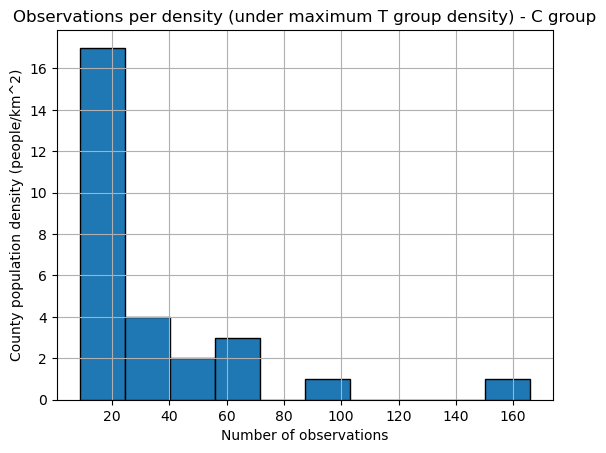

In [311]:
print(control_d["Population density (people/km^2)"].min(),control_d["Population density (people/km^2)"].max())
plt.hist(control_d["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - C group')
#plt.ylim(0, 3000)
plt.grid(True)
plt.show()
#savefig("../../results_summary/density_control_hist_0.png")

In [336]:
# treatment group analysis
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")
print(f"Size of the treatment group: {treatment.guessed_store_county_fips.count()}.")
treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()

Size of the treatment group: 9.
Size of the treatment group: 216.


C:\Users\inesn\AppData\Local\Temp\ipykernel_35628\3664718350.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()


In [337]:
treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).count().head(50)

is_walmart  \
store_state guessed_store_county_fips guessed_store_county               
SC          45007                     ANDERSON                      24   
            45013                     BEAUFORT                      24   
            45031                     DARLINGTON                    24   
            45043                     GEORGETOWN                    24   
            45045                     GREENVILLE                    24   
            45047                     GREENWOOD                     24   
            45063                     LEXINGTON                     24   
            45085                     SUMTER                        24   
            45091                     YORK                          24   

                                                            purchase_year  \
store_state guessed_store_county_fips guessed_store_county                  
SC          45007                     ANDERSON                         24   
            45013                     BEAUFORT                         24   
            45031                     DARLINGTON                       24   
            45043                     GEORGETOWN                       24   
            45045                     GREENVILLE                       24   
            45047                     GREENWOOD                        24   
            45063                     LEXINGTON                        24   
            45085                     SUMTER                           24   
            45091                     YORK                             24   

                                                            purchase_month  \
store_state guessed_store_county_fips guessed_store_county                   
SC          45007                     ANDERSON                          24   
            45013                     BEAUFORT                          24   
            45031                     DARLINGTON                        24   
            45043                     GEORGETOWN                        24   
            45045                     GREENVILLE                        24   
            45047                     GREENWOOD                         24   
            45063                     LEXINGTON                         24   
            45085                     SUMTER                            24   
            45091                     YORK                              24   

                                                            product_group_descr  \
store_state guessed_store_county_fips guessed_store_county                        
SC          45007                     ANDERSON                               24   
            45013                     BEAUFORT                               24   
            45031                     DARLINGTON                             24   
            45043                     GEORGETOWN                             24   
            45045                     GREENVILLE                             24   
            45047                     GREENWOOD                              24   
            45063                     LEXINGTON                              24   
            45085                     SUMTER                                 24   
            45091                     YORK                                   24   

                                                            upc_price  \
store_state guessed_store_county_fips guessed_store_county              
SC          45007                     ANDERSON                     24   
            45013                     BEAUFORT                     24   
            45031                     DARLINGTON                   24   
            45043                     GEORGETOWN                   24   
            45045                     GREENVILLE                   24   
            45047                     GREENWOOD                    24   
            45063                     LE

In [338]:
treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean().head(50)

C:\Users\inesn\AppData\Local\Temp\ipykernel_35628\4114228560.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean().head(50)


is_walmart  \
store_state guessed_store_county_fips guessed_store_county               
SC          45007                     ANDERSON                     0.0   
            45013                     BEAUFORT                     0.0   
            45031                     DARLINGTON                   0.0   
            45043                     GEORGETOWN                   0.0   
            45045                     GREENVILLE                   0.0   
            45047                     GREENWOOD                    0.0   
            45063                     LEXINGTON                    0.0   
            45085                     SUMTER                       0.0   
            45091                     YORK                         0.0   

                                                            purchase_year  \
store_state guessed_store_county_fips guessed_store_county                  
SC          45007                     ANDERSON                     2015.5   
            45013                     BEAUFORT                     2015.5   
            45031                     DARLINGTON                   2015.5   
            45043                     GEORGETOWN                   2015.5   
            45045                     GREENVILLE                   2015.5   
            45047                     GREENWOOD                    2015.5   
            45063                     LEXINGTON                    2015.5   
            45085                     SUMTER                       2015.5   
            45091                     YORK                         2015.5   

                                                            purchase_month  \
store_state guessed_store_county_fips guessed_store_county                   
SC          45007                     ANDERSON                         6.5   
            45013                     BEAUFORT                         6.5   
            45031                     DARLINGTON                       6.5   
            45043                     GEORGETOWN                       6.5   
            45045                     GREENVILLE                       6.5   
            45047                     GREENWOOD                        6.5   
            45063                     LEXINGTON                        6.5   
            45085                     SUMTER                           6.5   
            45091                     YORK                             6.5   

                                                            upc_price  \
store_state guessed_store_county_fips guessed_store_county              
SC          45007                     ANDERSON               2.825719   
            45013                     BEAUFORT               3.538399   
            45031                     DARLINGTON             3.303438   
            45043                     GEORGETOWN             2.884450   
            45045                     GREENVILLE             3.005567   
            45047                     GREENWOOD              3.002315   
            45063                     LEXINGTON              2.946135   
            45085                     SUMTER                 3.024388   
            45091                     YORK                   2.997974   

                                                            upc_price_std  \
store_state guessed_store_county_fips guessed_store_county                  
SC          45007                     ANDERSON                   1.054810   
            45013                     BEAUFORT                   1.667565   
            45031                     DARLINGTON                 1.414619   
            45043                     GEORGETOWN                 0.926784   
            45045                     GREENVILLE                 1.459888   
            45047                     GREENWOOD                  1.376419   
            45063                     LEXINGTON                  1.279310   
            45085                     SUM

29.2250338775805 245.119501334035


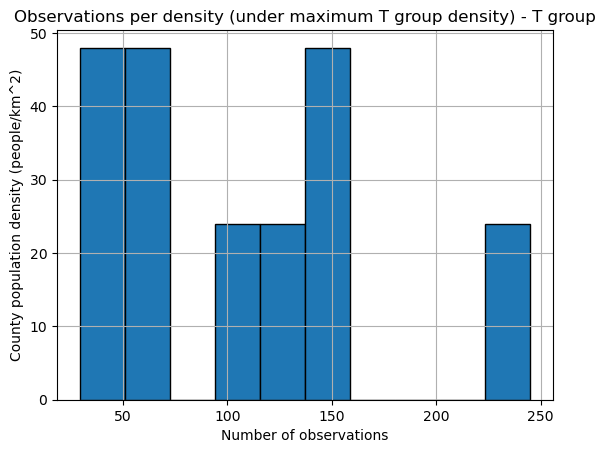

In [342]:
print(treatment["Population density (people/km^2)"].min(),treatment["Population density (people/km^2)"].max())
plt.hist(treatment["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - T group')
#plt.ylim(0, 3000)
plt.grid(True)
plt.show()
#savefig("../../results_summary/density_control_hist_0.png")

29.2250338775805 245.119501334035


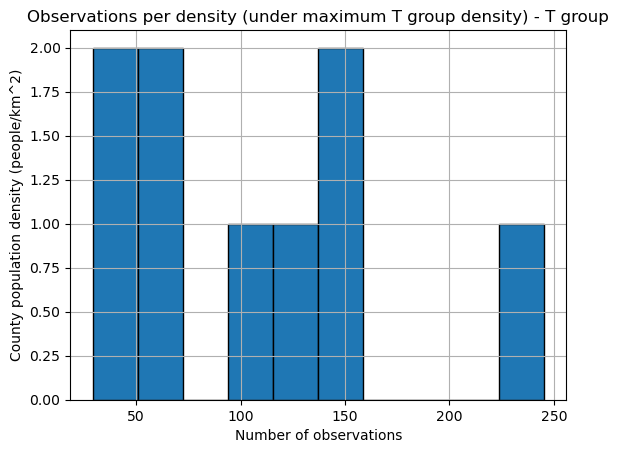

In [313]:
print(treatment_d["Population density (people/km^2)"].min(),treatment_d["Population density (people/km^2)"].max())
plt.hist(treatment_d["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - T group')
#plt.ylim(0, 3000)
plt.grid(True)
plt.show()
#savefig("../../results_summary/density_control_hist_0.png")

### 2. Visualising our regression results across time (fitted_values and residuals) (impact of density)

#### 2.1. On entire dataset

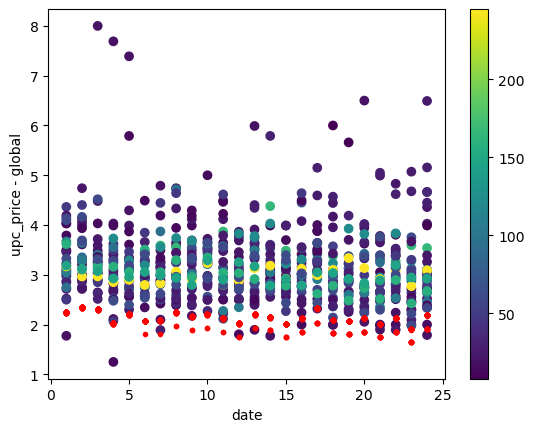

In [343]:
plt.scatter('date','upc_price', data = new, c=new['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - global')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

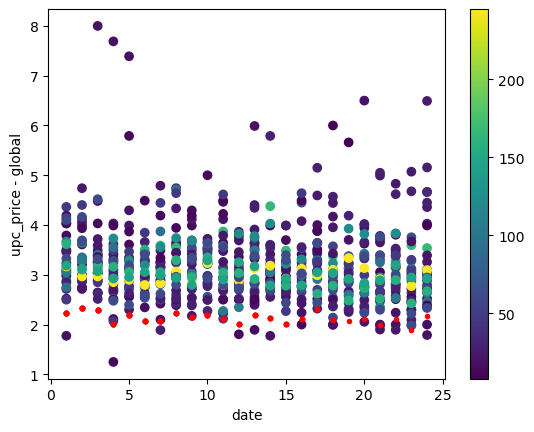

In [351]:
plt.scatter('date','upc_price', data = new, c=new['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_t_ni, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - global')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

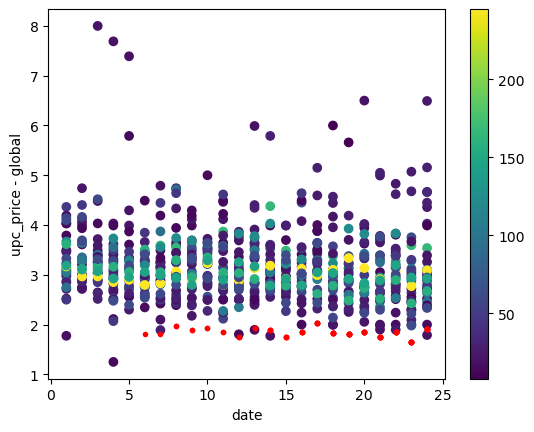

In [352]:
plt.scatter('date','upc_price', data = new, c=new['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - global')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

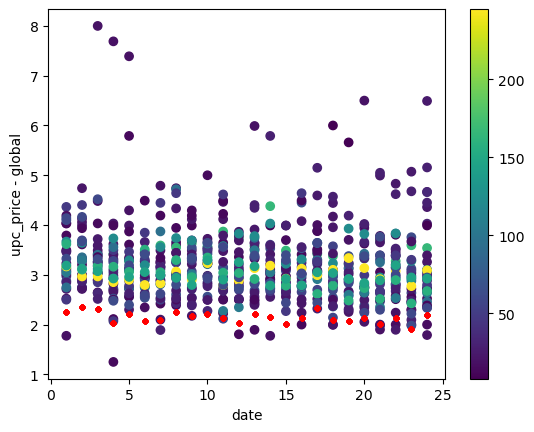

In [350]:
plt.scatter('date','upc_price', data = new, c=new['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_c, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - global')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

In [348]:
new.groupby("date")["fitted_value"].nunique()

date
1     2
2     2
3     2
4     2
5     2
6     3
7     3
8     3
9     3
10    3
11    3
12    3
13    3
14    3
15    3
16    3
17    3
18    3
19    3
20    3
21    3
22    3
23    3
24    3
Name: fitted_value, dtype: int64

#### 2.2. For control group

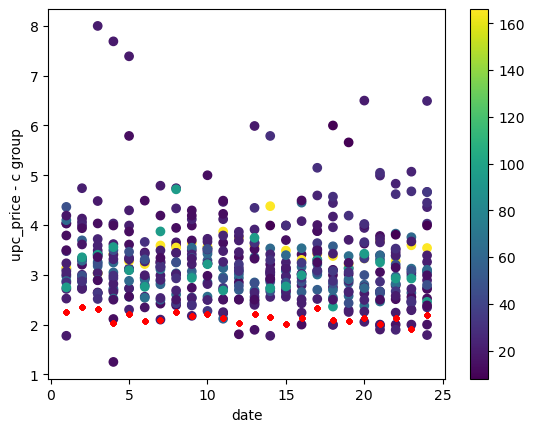

In [315]:
plt.scatter('date','upc_price', data = new_c, c=new_c['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_c, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - c group')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

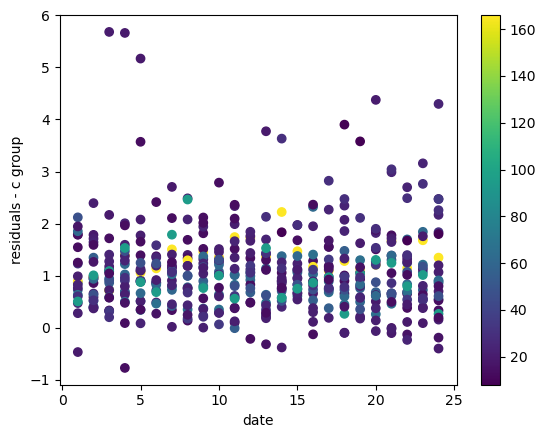

In [316]:
plt.scatter('date','residual', data = new_c, c=new_c['Population density (people/km^2)'].astype(int).to_numpy())
#plt.plot('date','fitted_value', data = new_c, color='red', marker='.', linestyle='')
plt.ylabel('residuals - c group')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

#### 2.3. For treatment group before entry

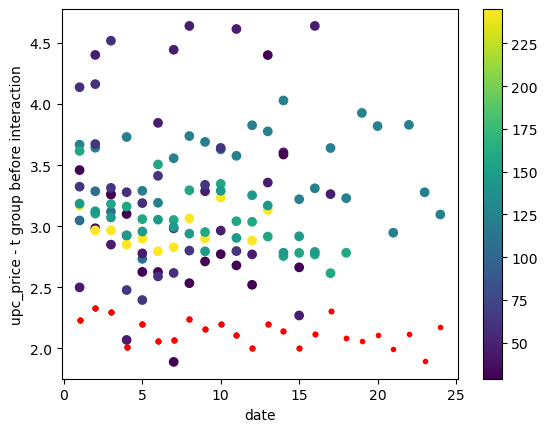

In [317]:
plt.scatter('date','upc_price', data = new_t_ni, c=new_t_ni['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_t_ni, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - t group before interaction')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

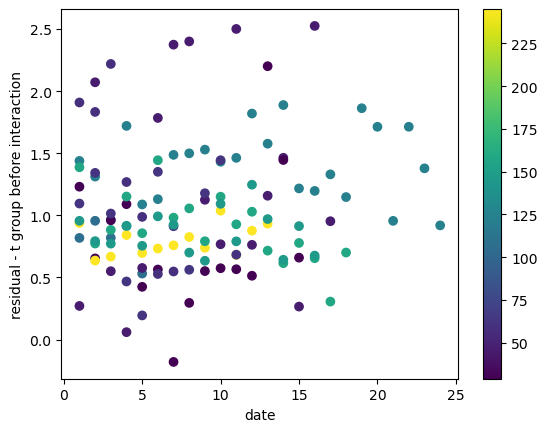

In [318]:
plt.scatter('date','residual', data = new_t_ni, c=new_t_ni['Population density (people/km^2)'].astype(int).to_numpy())
#plt.plot('date','fitted_value', data = new_t_ni, color='red', marker='.', linestyle='')
plt.ylabel('residual - t group before interaction')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

#### 2.4. For treatment group after entry

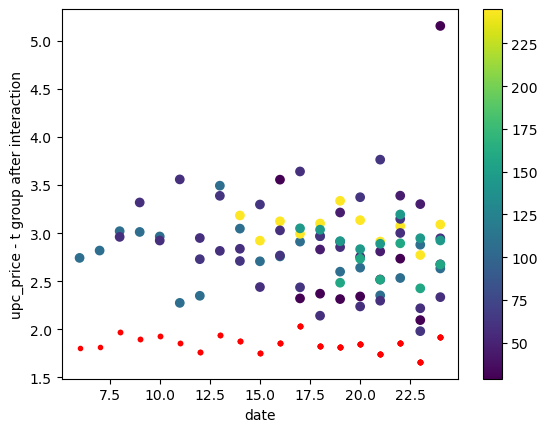

In [319]:
plt.scatter('date','upc_price', data = new_t_i, c=new_t_i['Population density (people/km^2)'].astype(int).to_numpy())
plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('upc_price - t group after interaction')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

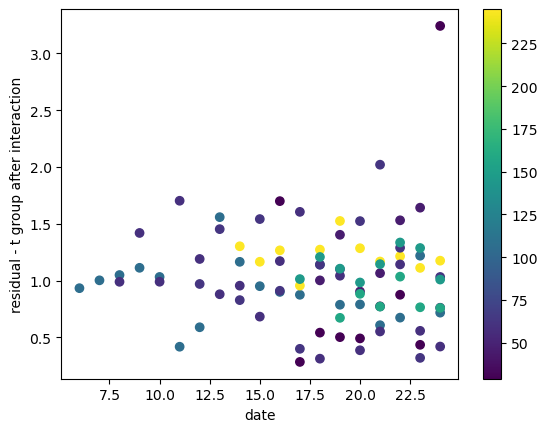

In [320]:
plt.scatter('date','residual', data = new_t_i, c=new_t_i['Population density (people/km^2)'].astype(int).to_numpy())
#plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('residual - t group after interaction')
plt.xlabel('date')
plt.colorbar()
#plt.xlim(445,455)

### 3. Identifying counties for which residuals (aggregated SSR) are maximal/minimal

#### 3.1. Counties sorted by aggregated SSR

In [355]:
df_SSR = new.groupby(['store_state', 'guessed_store_county',
       'guessed_store_county_fips']).mean()
df_SSR['SSR']=np.sqrt(df_SSR['s_residual'])
df_SSR = df_SSR[['SSR']].sort_values(by=["SSR"])
df_SSR.head(50)

C:\Users\inesn\AppData\Local\Temp\ipykernel_35628\1524736469.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  'guessed_store_county_fips']).mean()


SSR
store_state guessed_store_county guessed_store_county_fips          
SC          JASPER               45053                      0.275150
            FLORENCE             45041                      0.748505
            MARLBORO             45069                      0.804997
            AIKEN                45003                      0.825425
            CHEROKEE             45021                      0.859305
            EDGEFIELD            45037                      0.903969
            LEXINGTON            45063                      0.912166
            BARNWELL             45011                      0.926347
            ANDERSON             45007                      0.931665
            KERSHAW              45055                      0.932081
            HAMPTON              45049                      0.950847
            YORK                 45091                      0.973593
            OCONEE               45073                      1.009562
            GREENVILLE           45045                      1.022367
            CHESTERFIELD         45025                      1.029690
            ORANGEBURG           45075                      1.091279
            CHESTER              45023                      1.094646
            GEORGETOWN           45043                      1.100912
            PICKENS              45077                      1.106033
            SUMTER               45085                      1.119214
            GREENWOOD            45047                      1.171444
            CALHOUN              45017                      1.182917
            LANCASTER            45057                      1.215777
            SALUDA               45081                      1.295368
            CHARLESTON           45019                      1.369855
            BEAUFORT             45013                      1.436076
            DARLINGTON           45031                      1.438667
            BAMBERG              45009                      1.456922
            NEWBERRY             45071                      1.461778
            WILLIAMSBURG         45089                      1.515509
            MARION               45067                      1.691287
            CLARENDON            45027                      1.718125
            COLLETON             45029                      1.896475
            ABBEVILLE            45001                      2.319424
            UNION                45087                      2.332788
            DILLON               45033                      2.493513
            ALLENDALE            45005                      2.735350

In [362]:
df_n = pd.merge(df_SSR, new, on = ['store_state', 'guessed_store_county',
       'guessed_store_county_fips'])
df_n = df_n.sort_values(by=['SSR'])
df_n.head(60)

,store_state,guessed_store_county,guessed_store_county_fips,SSR,upc_price,nb_of_obs,Population density (people/km^2),treat,interaction,time_effects,Opening_date,Closing_date,fitted_value,residual,date,s_residual
0,SC,JASPER,45053,0.275150,2.645000,2,16.442123,False,False,"(2015, 3)",NaT,NaT,2.316706,0.328294,3,0.107777
1,SC,JASPER,45053,0.275150,2.500000,1,16.442123,False,False,"(2015, 4)",NaT,NaT,2.026067,0.473933,4,0.224612
2,SC,JASPER,45053,0.275150,2.345000,2,16.442123,False,False,"(2015, 6)",NaT,NaT,2.077932,0.267068,6,0.071325
3,SC,JASPER,45053,0.275150,2.500000,1,16.442123,False,False,"(2015, 11)",NaT,NaT,2.129877,0.370123,11,0.136991
4,SC,JASPER,45053,0.275150,2.000000,1,16.442123,False,False,"(2016, 6)",NaT,NaT,2.098752,-0.098752,18,0.009752
5,SC,JASPER,45053,0.275150,2.000000,1,16.442123,False,False,"(2016, 9)",NaT,NaT,2.007264,-0.007264,21,0.000053
6,SC,JASPER,45053,0.275150,2.000000,1,16.442123,False,False,"(2016, 10)",NaT,NaT,2.132901,-0.132901,22,0.017663
7,SC,JASPER,45053,0.275150,2.000000,1,16.442123,False,False,"(2016, 12)",NaT,NaT,2.193611,-0.193611,24,0.037485
23,SC,FLORENCE,45041,0.748505,3.533889,36,66.830742,False,False,"(2016, 4)",NaT,NaT,2.130468,1.403421,16,1.969590
24,SC,FLORENCE,45041,0.748505,3.004615,26,66.830742,False,False,"(2016, 5)",NaT,NaT,2.327563,0.677052,17,0.458400


####  3.2. Impact of density on aggregated SSR

Text(0.5, 0, 'Density')

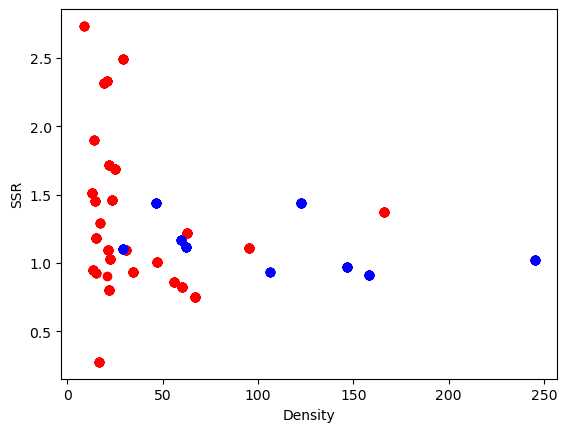

In [357]:
plt.scatter('Population density (people/km^2)','SSR', data = df_n[~df_n.treat], c='red')
plt.scatter('Population density (people/km^2)','SSR', data = df_n[(df_n.treat)&(~df_n.interaction)], c='blue')
#plt.scatter('Population density (people/km^2)','SSR', data = df_n[(df_n.treat)&(df_n.interaction)], c='yellow', marker = '.')
#plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('SSR')
plt.xlabel('Density')
#plt.xlim(445,455)df_n['treat'].astype(int).to_numpy()

####  3.3. Impact of price on aggregated SSR ??? Not relevant ?

Text(0.5, 0, 'upc_price')

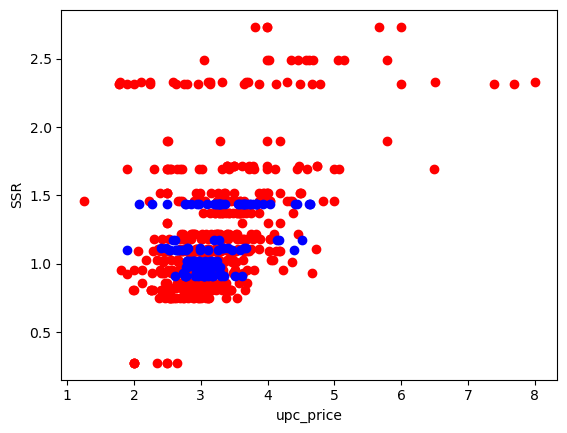

In [358]:
plt.scatter('upc_price','SSR', data = df_n[~df_n.treat], c='red')
plt.scatter('upc_price','SSR', data = df_n[(df_n.treat)&(~df_n.interaction)], c='blue')
#plt.scatter('Population density (people/km^2)','SSR', data = df_n[(df_n.treat)&(df_n.interaction)], c='yellow', marker = '.')
#plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('SSR')
plt.xlabel('upc_price')
#plt.xlim(445,455)df_n['treat'].astype(int).to_numpy()

#### 3.4. Impact of the number of observations on aggregated SSR

Text(0.5, 0, 'nb_of_obs')

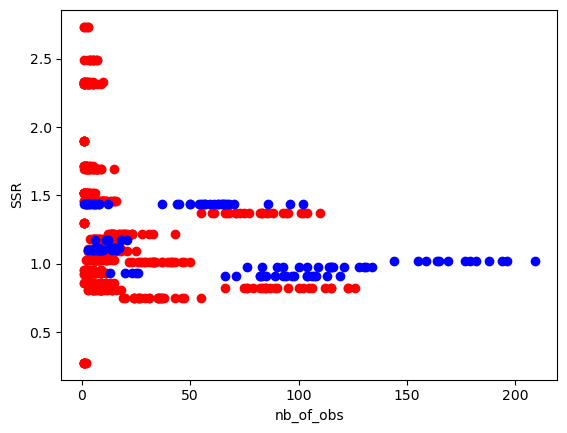

In [359]:
plt.scatter('nb_of_obs','SSR', data = df_n[~df_n.treat], c='red')
plt.scatter('nb_of_obs','SSR', data = df_n[(df_n.treat)&(~df_n.interaction)], c='blue')
#plt.scatter('Population density (people/km^2)','SSR', data = df_n[(df_n.treat)&(df_n.interaction)], c='yellow', marker = '.')
#plt.plot('date','fitted_value', data = new_t_i, color='red', marker='.', linestyle='')
plt.ylabel('SSR')
plt.xlabel('nb_of_obs')
#plt.xlim(445,455)df_n['treat'].astype(int).to_numpy()